In [1]:
import adlfs
import fsspec
import xarray as xr

# import dask_gateway
# cluster = dask_gateway.GatewayCluster()
# client = cluster.get_client()
# cluster.scale(8)
# cluster

In [2]:
store = fsspec.get_mapper('az://daymet-zarr/monthly/na.zarr', account_name="daymeteuwest")
ds = xr.open_zarr(store, consolidated=True)
ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 492, x: 7814, y: 8075)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-01-16T12:00:00 ... 20...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(12, 2000, 2000), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(12, 2000, 2000), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(12, 2000, 2000), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(12, 2000, 2000), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(12, 2000, 2000), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    NCO:               netCDF Operators version 4.9.3 (Homepage = http://nco....
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        1980

In [3]:
ds.tmax.sel(time=slice("2019-02-01", "2019-12-16")).time.values

array(['2019-02-15T00:00:00.000000000', '2019-03-16T12:00:00.000000000',
       '2019-04-16T00:00:00.000000000', '2019-05-16T12:00:00.000000000',
       '2019-06-16T00:00:00.000000000', '2019-07-16T12:00:00.000000000',
       '2019-08-16T12:00:00.000000000', '2019-09-16T00:00:00.000000000',
       '2019-10-16T12:00:00.000000000', '2019-11-16T00:00:00.000000000',
       '2019-12-16T12:00:00.000000000'], dtype='datetime64[ns]')

In [4]:
# If you want to speed up iterations, coarsen by a factor of `factor` here (1 == noop)
factor=1
with xr.set_options(keep_attrs=True):
    t = ds.tmax.sel(time="2019-02-15", method="nearest").coarsen(dim={'x': factor, 'y': factor}, boundary="trim").mean().compute()
    p = ds.prcp.sel(time="2019-02-15", method="nearest").coarsen(dim={'x': factor, 'y': factor}, boundary="trim").mean().compute()
    vp = ds.vp.sel(time="2019-02-15", method="nearest").coarsen(dim={'x': factor, 'y': factor}, boundary="trim").mean().compute()


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [5]:
import cartopy.crs as ccrs

lcc = ds.variables["lambert_conformal_conic"].attrs

prj_kwargs = dict(
    central_latitude=lcc['latitude_of_projection_origin'],
    central_longitude=lcc['longitude_of_central_meridian'],
    standard_parallels=(lcc["standard_parallel"])
)

prj = ccrs.LambertConformal(**prj_kwargs)

In [6]:
import cartopy
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean

def pl(da, cmap):
    fig = plt.figure(figsize=(15,8), dpi=200)

    ax = plt.axes(projection=prj)
    ax.set_extent([-145, -58, 9, 84])
    da.plot(ax=ax, transform=prj, cmap=cmap, cbar_kwargs={"aspect": 50}, robust=True)

    ax.add_feature(cartopy.feature.OCEAN, zorder=0)
    ax.add_feature(cartopy.feature.LAND, zorder=0, linewidth=0, facecolor="#f7f7ed")

    countries = cartopy.feature.NaturalEarthFeature(category='cultural', 
        name='admin_0_countries', scale="10m", facecolor="none")
    states = cartopy.feature.NaturalEarthFeature(category='cultural', 
        name='admin_1_states_provinces_lines', scale="10m", facecolor="none")
    lakes = cartopy.feature.NaturalEarthFeature('physical', 'lakes',
        scale="110m", facecolor=cfeature.COLORS['water'])

    ax.add_feature(countries, zorder=2, linewidth=0.2, edgecolor="lightgray")
    ax.add_feature(states, zorder=3, linewidth=0.2, edgecolor="lightgray")
    ax.add_feature(lakes, zorder=4, linewidth=0.3, edgecolor="lightgray")
    


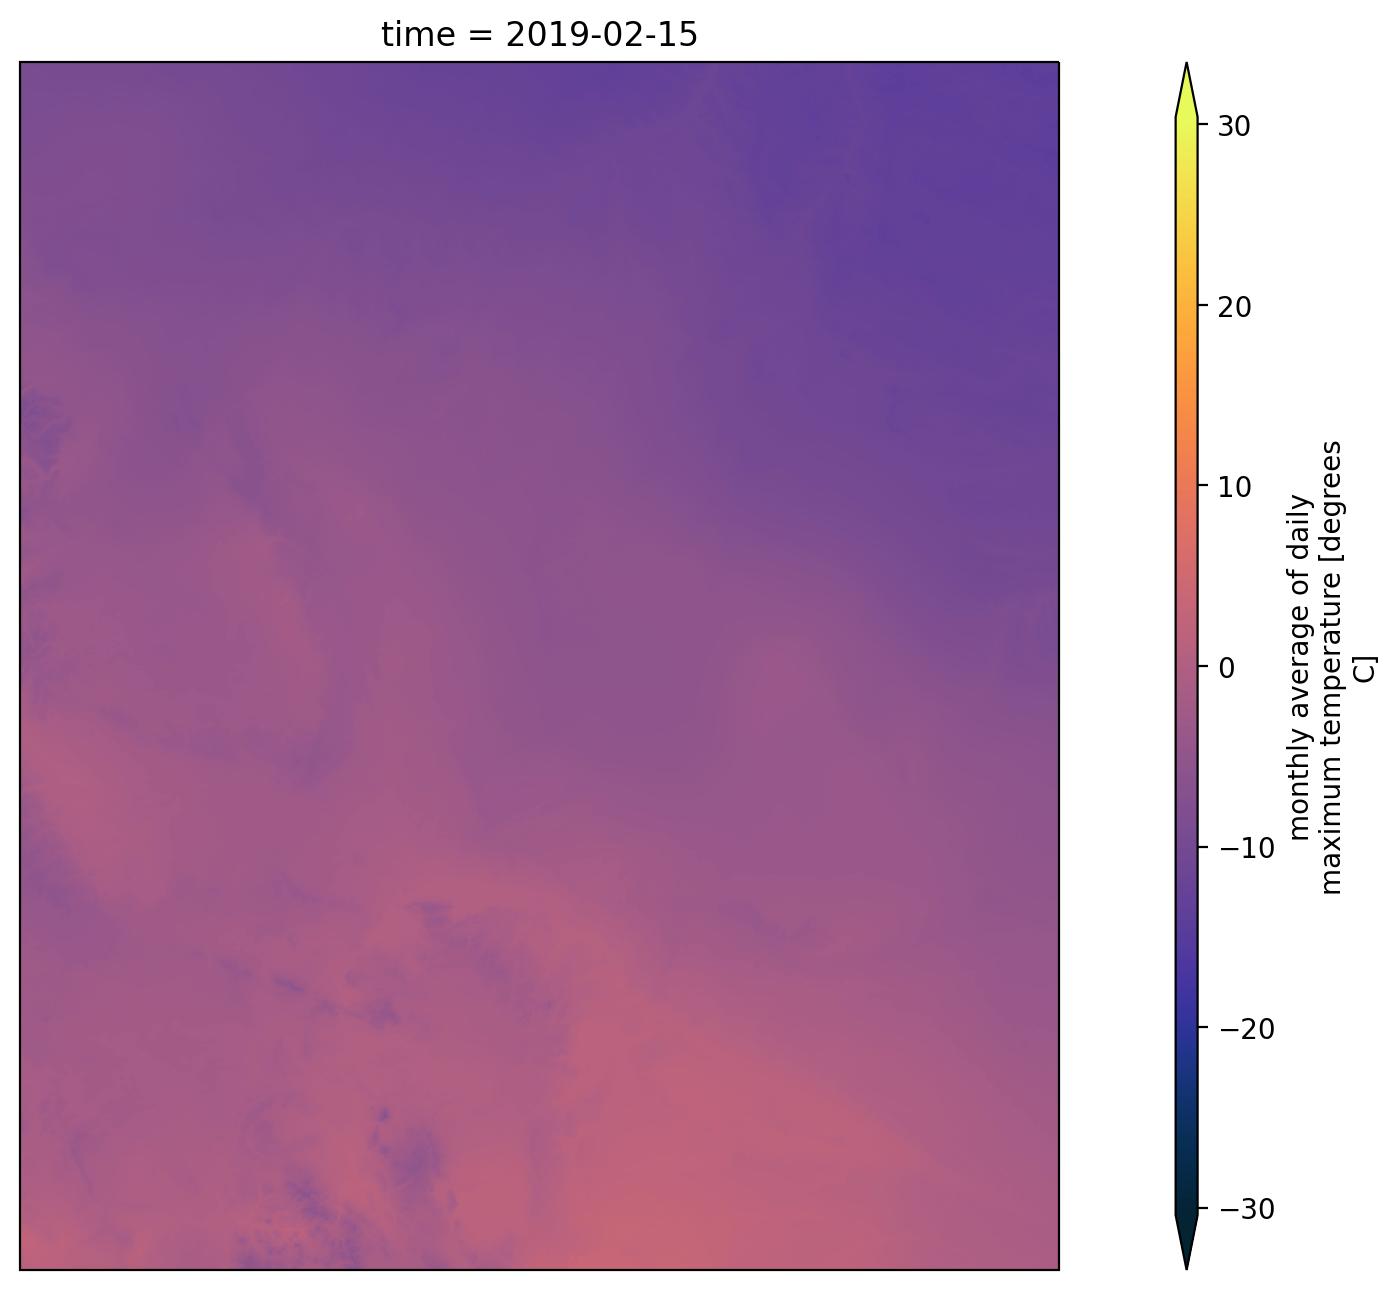

In [7]:
pl(t, cmocean.cm.thermal)

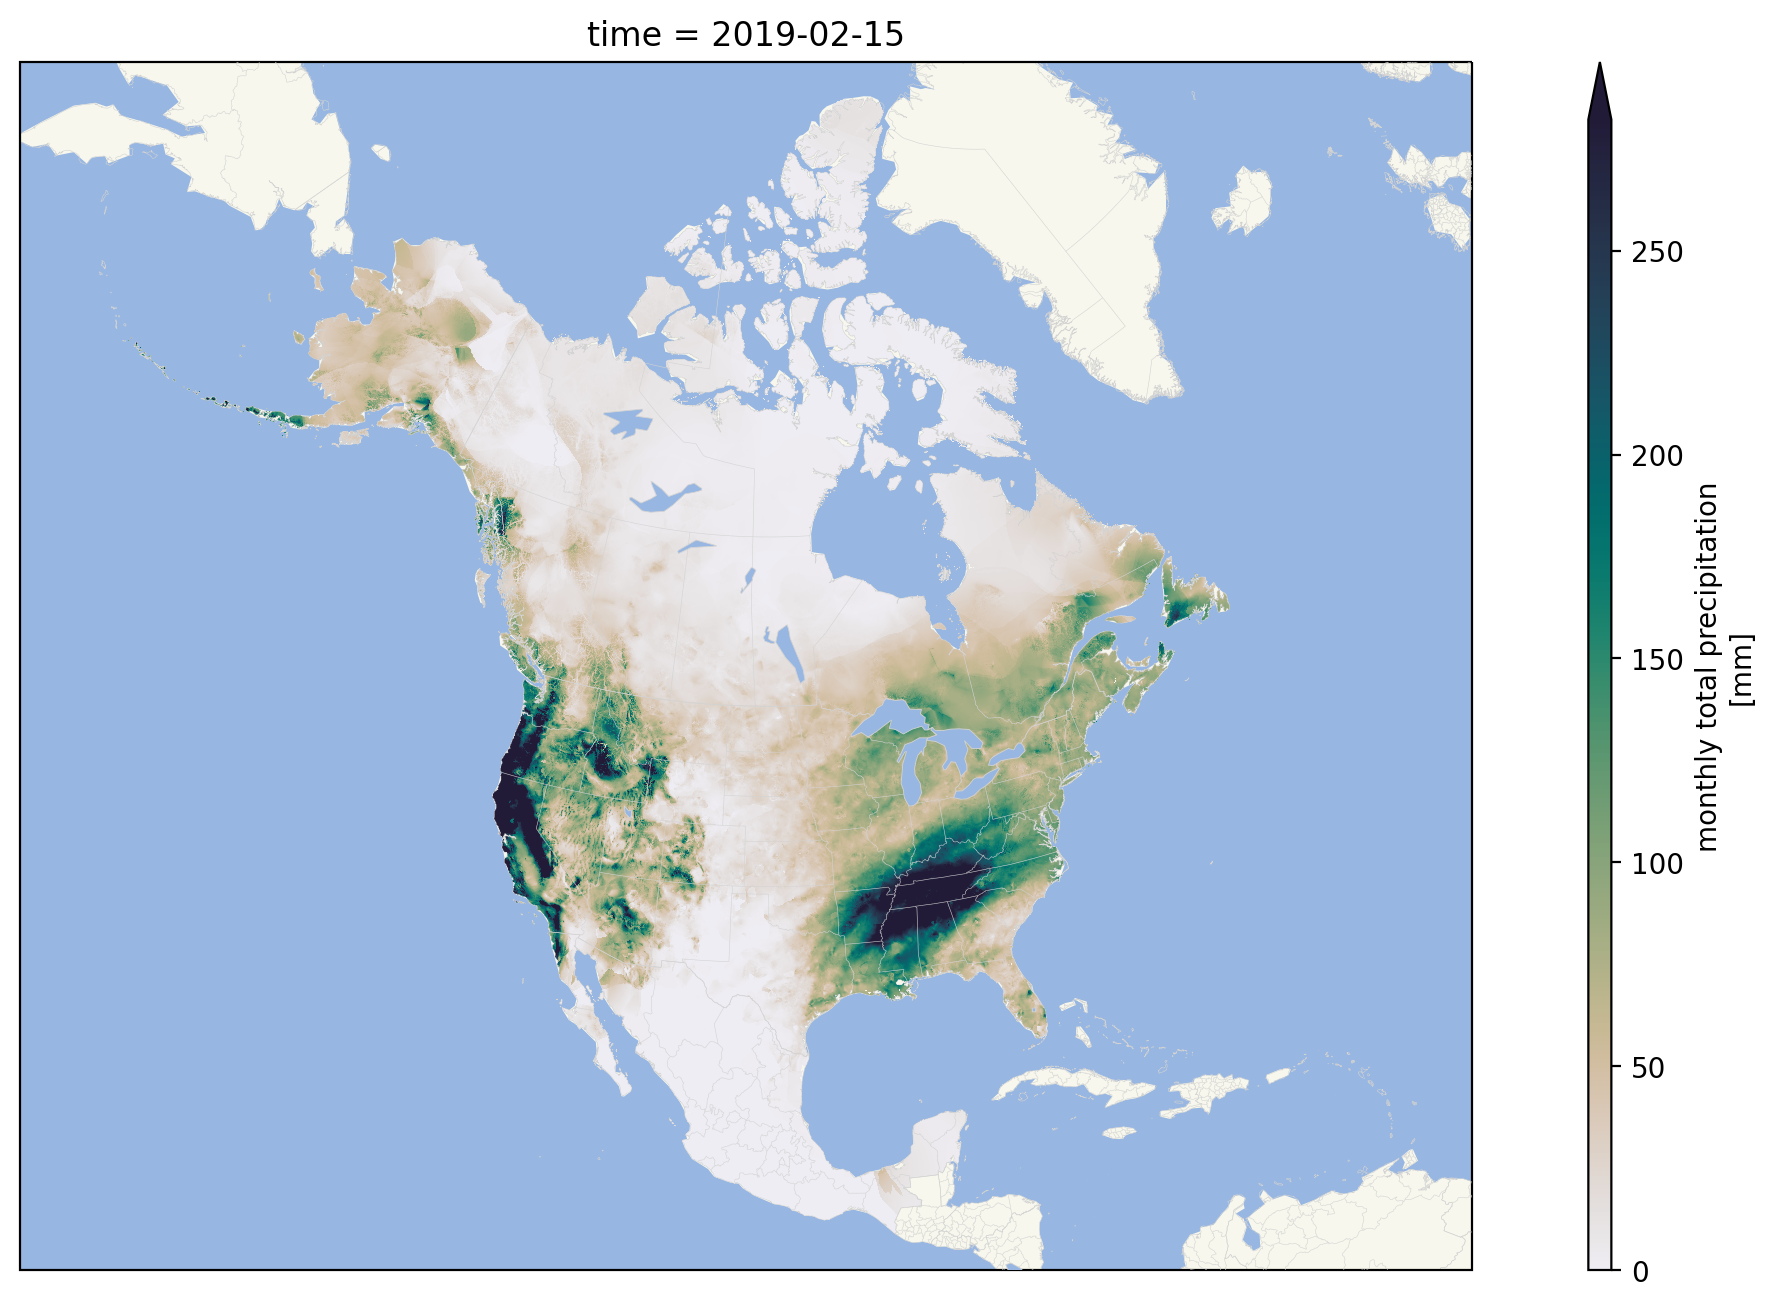

In [25]:
pl(p, cmocean.cm.rain)

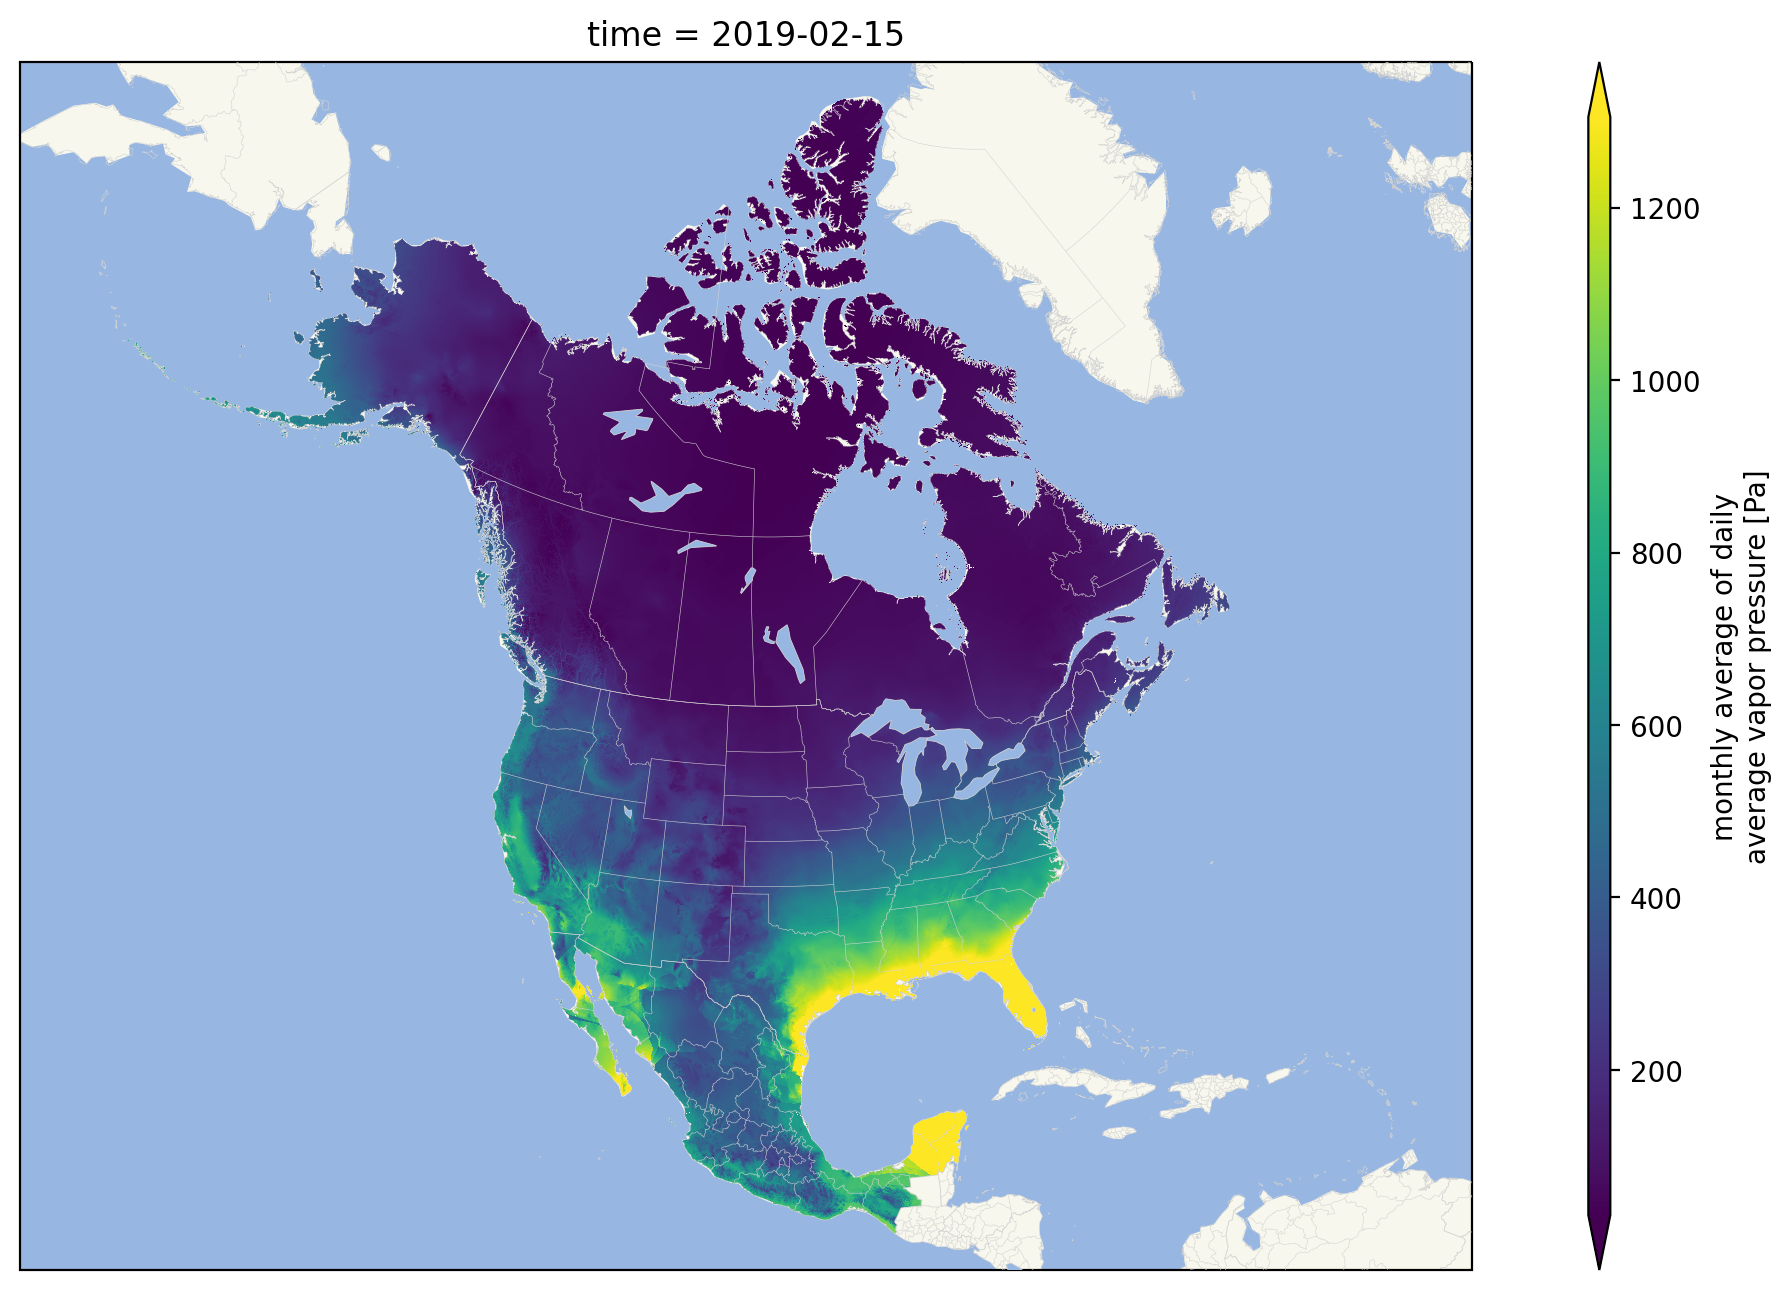

In [24]:
pl(vp, "viridis")

In [7]:
from shapely.geometry import shape
import matplotlib.pyplot as plt
poly = {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -123.92578125,
              32.82421110161336
            ],
            [
              -108.74267578125,
              32.82421110161336
            ],
            [
              -108.74267578125,
              41.73852846935917
            ],
            [
              -123.92578125,
              41.73852846935917
            ],
            [
              -123.92578125,
              32.82421110161336
            ]
          ]
        ]
      }

minx, miny, maxx, maxy = shape(poly).bounds
#t1 = t.sel(lat=slice(miny, maxy), lon=slice(minx, maxx))





In [ ]:
fig = plt.figure(figsize=(20,10), dpi=200)
ax = plt.axes(projection=prj, frameon=False)

p1 = p.sel(y=slice(1_050_000, 648), x=slice(-1_600_000, -100_000))
p1.plot(ax=ax, transform=prj, cmap=cmocean.cm.rain, cbar_kwargs={"aspect": 50}, robust=True)

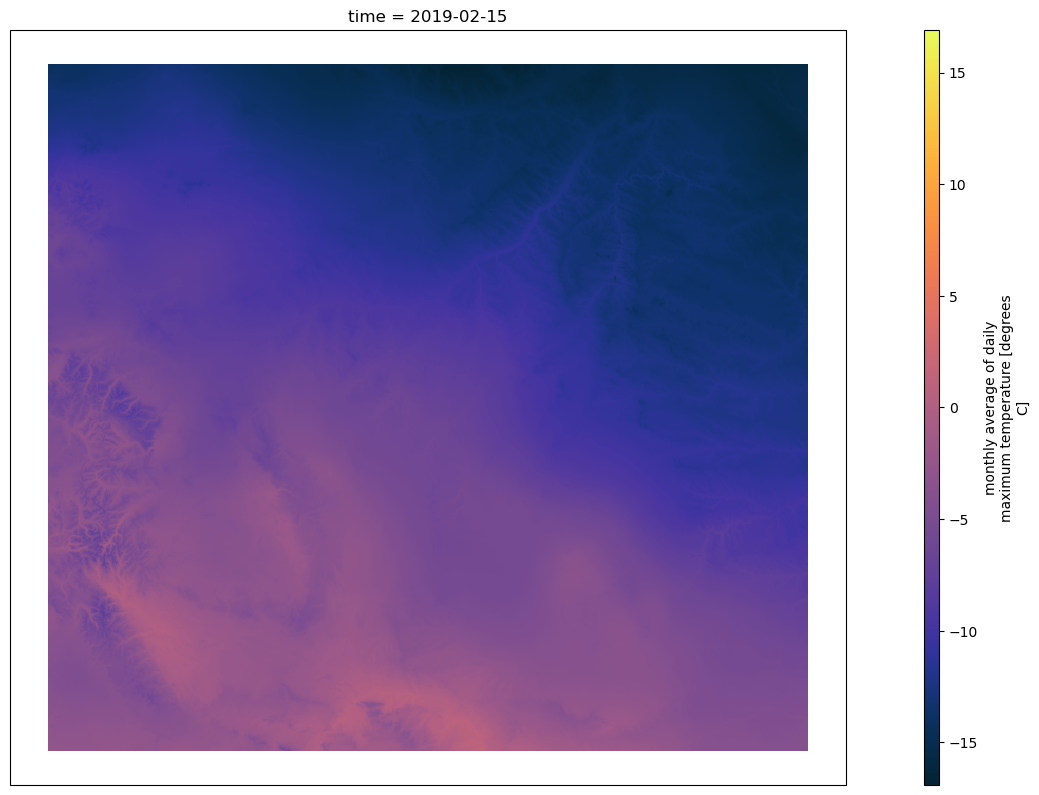

In [32]:
fig = plt.figure(figsize=(20,10), dpi=100)
ax = plt.axes(projection=prj)

p1 = t.sel(y=slice(650_000, 648), x=slice(-800_000, -80_000))
p1.plot(ax=ax, transform=prj, cmap=cmocean.cm.thermal, cbar_kwargs={"aspect": 50})